In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta

In [2]:
#função para tratar campo data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

#Agora vamos importar nosso arquivo 
df = pd.read_excel('biometria.xlsx', sheet_name='Página1')
print(df.tail(10))

     Index    peso  comprimento_Total  comprimento_Padrao  comprimento_Cabeca  \
664  665.0  492.04               29.0                24.8                 8.0   
665  666.0  454.02               27.0                23.0                 7.6   
666  667.0  480.56               27.1                22.8                 7.5   
667  668.0  412.75               25.7                22.0                 7.5   
668  669.0  471.80               27.2                23.4                 7.4   
669  670.0  382.79               25.4                21.5                 7.5   
670  671.0  401.90               26.5                22.3                 7.2   
671  672.0  441.98               27.8                23.4                 7.5   
672  673.0  468.54               28.0                23.5                 7.8   
673  674.0  418.14               26.3                22.2                 7.4   

     altura  espessura       data  
664     9.1        3.2 2024-06-12  
665     9.0        3.2 2024-06-12  


In [3]:
df1 = df.drop(columns=[
'data', 
'Index'
])
df1.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura
0,51.45,14.3,12.2,4.0,4.1,1.9
1,37.15,12.4,10.9,3.8,3.2,1.2
2,47.26,13.7,11.2,3.4,4.0,1.7
3,36.67,12.9,11.1,3.7,3.7,1.6
4,45.48,13.2,11.3,3.8,4.5,1.6


## Creating the unseen_Data of 10% of the real data to check model results

In [4]:
data = df1.sample(frac=0.95, random_state=123)
data_unseen = df1.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (640, 6)
Unseen Data For Predictions: (34, 6)


In [5]:
for col in data.select_dtypes(include='number').columns:
    print(col)

peso
comprimento_Total
comprimento_Padrao
comprimento_Cabeca
altura
espessura


In [6]:
# Run this cel to make sure all the variable are type float64!
#data.info()

In [7]:
#from pycaret.datasets import get_data
#boston = get_data('boston')
from pycaret.regression import *
exp1 = setup(data = data,  target = 'peso', session_id=124, train_size=0.8, preprocess=False)


In [ ]:
best_model = compare_models(n_select=5 )  #default R2 sort='R2' TO select the metric R2

In [ ]:
best_model

[RandomForestRegressor(n_jobs=-1, random_state=124),
 ExtraTreesRegressor(n_jobs=-1, random_state=124),
 LGBMRegressor(n_jobs=-1, random_state=124),
 AdaBoostRegressor(random_state=124),
 GradientBoostingRegressor(random_state=124)]

## Create Model
#### This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function. All the available models can be accessed using the models function.

In [ ]:
rf = exp1.create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:25:56
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7141,48.8366,6.9883,0.9917,0.0476,0.0401
1,6.0541,86.3846,9.2943,0.9843,0.0580,0.0457
2,7.2716,120.0062,10.9547,0.9781,0.0682,0.0531
3,7.9549,186.6968,13.6637,0.9743,0.0661,0.0465
4,4.7031,41.6836,6.4563,0.9909,0.0597,0.0477
5,6.9701,118.8006,10.8996,0.9791,0.0639,0.0511
6,6.3011,79.4235,8.9120,0.9843,0.0751,0.0582
7,6.9448,103.5357,10.1752,0.9836,0.0614,0.0548
8,6.9747,89.5843,9.4649,0.9817,0.0654,0.0583


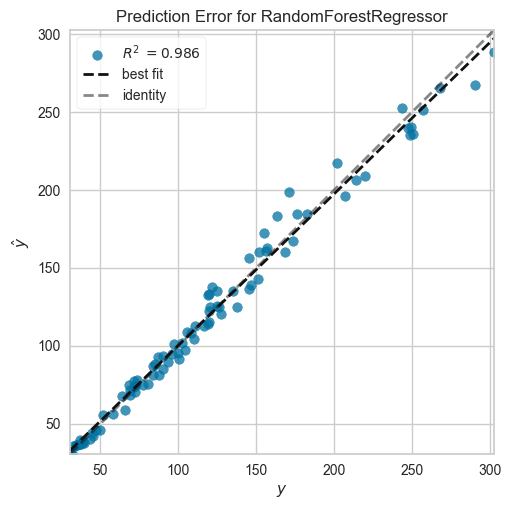

In [ ]:
#plot_model(et, plot = 'residuals')
plot_model(rf, plot = 'error')
#plot_model(et, plot = 'feature')

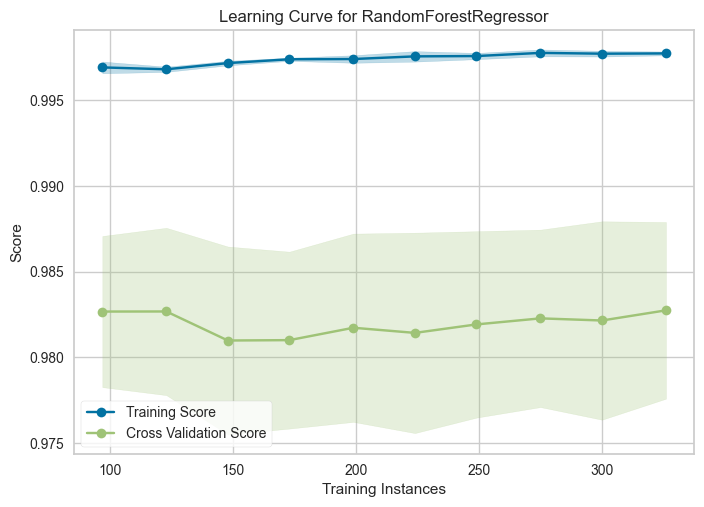

In [ ]:
plot_model(rf, plot = 'learning')

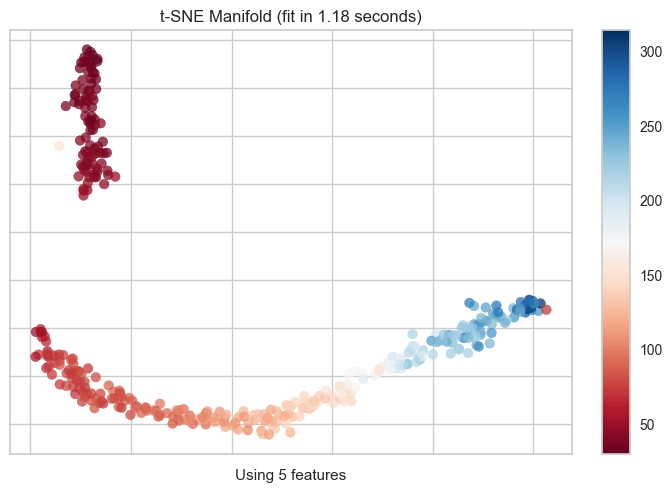

In [ ]:
exp1.plot_model(rf, plot = 'manifold')

## Blend an d sTacking if it is necessary!

In [ ]:
holdout_pred = exp1.predict_model(rf)
#holdout_pred.tail(5) # for the last  5 lines 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.8473,62.5293,7.9075,0.9862,0.0572,0.0494


In [ ]:
unseen_predictions = exp1.predict_model(rf, data=data_unseen)
unseen_predictions.head(5) # first five lines

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,5.1912,80.9981,8.9999,0.9822,0.0600,0.0499


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura,peso,prediction_label
0,12.7,10.8,3.3,3.7,1.6,37.130001,37.727100
1,13.0,11.0,3.3,4.2,1.8,46.599998,43.038401
2,12.2,10.3,3.1,3.6,1.6,33.959999,32.723100
3,13.4,11.2,3.3,4.0,1.8,43.389999,44.424900
4,12.7,10.9,3.2,3.6,1.6,36.990002,39.155700


## Tune model
#### This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

In [ ]:
tune_rf= exp1.tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4030,47.9526,6.9248,0.9919,0.0473,0.0383
1,5.6951,71.8295,8.4752,0.9870,0.0569,0.0454
2,7.2476,120.8787,10.9945,0.9780,0.0676,0.0515
3,7.9574,169.6305,13.0242,0.9767,0.0661,0.0484
4,4.6793,40.8606,6.3922,0.9911,0.0621,0.0484
5,6.1830,92.7286,9.6296,0.9837,0.0585,0.0474
6,6.7040,91.7068,9.5764,0.9819,0.0793,0.0598
7,6.2941,88.2909,9.3963,0.9860,0.0600,0.0515
8,6.7600,89.8118,9.4769,0.9817,0.0625,0.0558


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
pred_unseen = predict_model(tune_rf, data = data_unseen)
pred_unseen.head(5) # first five lines


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.9110,79.9002,8.9387,0.9825,0.0560,0.0467


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura,peso,prediction_label
0,12.7,10.8,3.3,3.7,1.6,37.130001,37.980262
1,13.0,11.0,3.3,4.2,1.8,46.599998,42.035793
2,12.2,10.3,3.1,3.6,1.6,33.959999,32.795634
3,13.4,11.2,3.3,4.0,1.8,43.389999,44.286533
4,12.7,10.9,3.2,3.6,1.6,36.990002,38.455375


In [ ]:
# dashboard of pycaret
#evaluate_model(rf)

# EXPERIMENT 2 
### Weight predicition using database from esalq esperiment without espessura feature.

#################################################### EXPERIMENT 2 #################################################33

In [ ]:
df2 = df.drop(columns=[
'data', 
'Index',
'espessura'
])
df2.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura
0,51.45,14.3,12.2,4.0,4.1
1,37.15,12.4,10.9,3.8,3.2
2,47.26,13.7,11.2,3.4,4.0
3,36.67,12.9,11.1,3.7,3.7
4,45.48,13.2,11.3,3.8,4.5


In [ ]:
data = df2.sample(frac=0.95, random_state=123)
data_unseen = df2.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (454, 5)
Unseen Data For Predictions: (24, 5)


In [ ]:
from pycaret.regression import *
exp2= setup(data = data,  target = 'peso')
#### WIthout unseen data
exp2= setup(data = df2,  target = 'peso')

best_model = exp2.compare_models()

NameError: name 'data' is not defined

In [ ]:
rf = exp2.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.6321,31.2497,5.5901,0.9806,0.0528,0.0413
1,4.2763,39.5584,6.2895,0.9534,0.0630,0.0508
2,4.1689,31.5230,5.6145,0.9818,0.0573,0.0460
3,5.5166,56.3391,7.5059,0.9563,0.0735,0.0603
4,4.2805,33.8638,5.8193,0.9788,0.0562,0.0475
5,4.2662,35.7581,5.9798,0.9787,0.0685,0.0553
6,3.0567,17.9646,4.2385,0.9886,0.0451,0.0369
7,4.0568,22.5276,4.7463,0.9847,0.0652,0.0525
8,3.7927,27.1386,5.2095,0.9816,0.0615,0.0520


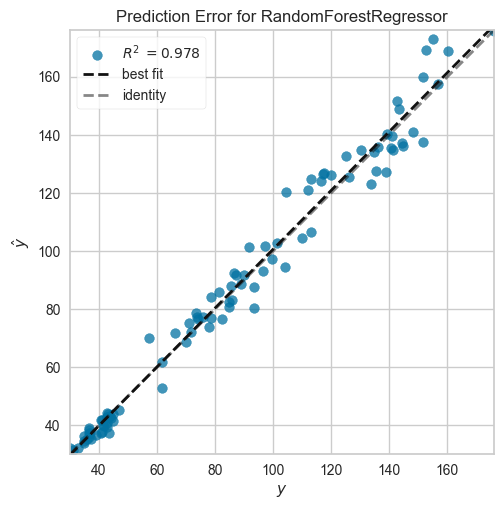

In [ ]:
exp2.plot_model(rf, plot = 'error')

In [ ]:
exp2.evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
peso_pred_semEspe = exp2.predict_model(rf)
#peso_pred_semEspe.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.4552,36.7836,6.0649,0.9783,0.0616,0.0501


In [ ]:
pred_unseen = predict_model(rf, data = data_unseen)
pred_unseen.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.0417,20.6230,4.5413,0.9840,0.0555,0.0411


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
0,13.7,11.2,3.4,4.0,47.259998,43.527500
1,12.7,10.8,3.3,3.7,37.130001,37.228599
2,13.0,11.0,3.3,4.2,46.599998,42.633700
3,11.8,9.9,3.2,3.5,30.740000,32.120600
4,12.2,10.3,3.1,3.6,33.959999,32.908400


In [ ]:
#tuned_gbr = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7974,39.0236,6.2469,0.9739,0.0576,0.0456
1,2.7883,14.7765,3.8440,0.9887,0.0520,0.0410
2,4.8336,41.1100,6.4117,0.9716,0.0620,0.0544
3,4.7503,38.9787,6.2433,0.9801,0.0600,0.0524
4,3.8073,27.0587,5.2018,0.9761,0.0642,0.0496
5,2.9277,16.8013,4.0989,0.9880,0.0495,0.0388
6,2.9499,18.5206,4.3036,0.9848,0.0476,0.0374
7,4.5485,36.9543,6.0790,0.9670,0.0627,0.0507
8,4.6366,43.4864,6.5944,0.9575,0.0646,0.0521


Fitting 10 folds for each of 10 candidates, totalling 100 fits


#### weight prediction 
#### Realizar um codigo padrao com avaliacao de modelos, tuning, evaluation, shuffle and save (retirar index)
#### realizar predicao para espessura
#### realizar a predicao do peso sem a variavel espessura

## TRy with biometria 4 
## importance study for each variable